# Arciva — LLM Assistant Proof of Concept

## Executive Summary
Arciva is a cross-platform photo library manager built with a FastAPI backend, React frontend, and a Rust-based processing core. This notebook documents the feasibility study for an in-app assistant that can answer workflow questions, guide photographers through Arciva's UI, and surface context-specific help.

The goal is to show that a compact model, fine-tuned with QLoRA, can internalize Arciva terminology and deliver useful assistant behavior while remaining deployable on edge hardware (e.g., Jetson-class devices). The pipeline covers end-to-end steps needed for a reproducible prototype:
1.  **Data Ingestion & Validation**: Load the synthetic Arciva Q&A corpus, perform sanity checks, and create evaluation splits.
2.  **Efficient Training**: Apply QLoRA adapters to a 7B base model (or an optional tiny debug model) for rapid iteration without large compute budgets.
3.  **Monitoring & Diagnostics**: Visualize training progress inside the notebook to catch regressions early.
4.  **Quantitative & Qualitative Review**: Compute PPL/BLEU/ROUGE and inspect representative generations to gauge assistant quality.
5.  **Interactive Exploration**: Provide a lightweight dashboard for browsing predictions across dataset splits.
6.  **Artifact Preparation**: Merge adapters back into the base weights and stage artifacts for downstream integration tests.

This artifact is included in Arciva applications to demonstrate practical LLM fine-tuning skills, data quality awareness, and a deployment-focused mindset.


## 1. Environment Configuration
This cell pins the Python dependencies required for the Arciva assistant prototype. Keeping installation commands at the top ensures Colab/RunPod sessions can be recreated quickly and makes debugging import errors straightforward. If `typing_extensions` or `pydantic` raise issues, restart the runtime and rerun this setup cell.


In [1]:
# 1. Core Dependency Upgrades (Must run first to avoid conflicts)
!pip install -U -q 'typing_extensions>=4.12.2' pydantic

# 2. ML Pipeline Installation
!pip install -q transformers peft trl bitsandbytes accelerate wandb scipy datasets matplotlib evaluate rouge_score sacrebleu pandas seaborn

import os
print("[SYSTEM] Environment Configuration Complete.")
print("[NOTE] If you see an import error below, please restart the runtime.")


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
[SYSTEM] Environment Configuration Complete.
[NOTE] If you see an import error below, please restart the runtime.


## 2. Library Imports & Global Configuration
All core libraries for fine-tuning, evaluation, and visualization are imported here. Global switches (e.g., enabling a tiny debug model) control whether we run a fast smoke test or a full QLoRA pass on the Arciva dataset, keeping experiments reproducible.


In [2]:
import torch
import gc
import time
import transformers
import trl
import peft
import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sacrebleu
from rouge_score import rouge_scorer
from IPython.display import clear_output, display
from datasets import load_dataset, Dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainerCallback,
    Trainer,
    TrainingArguments
)
from peft import LoraConfig, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer, SFTConfig
try:
    from google.colab import data_table
    HAS_COLAB = True
except ModuleNotFoundError:
    data_table = None
    HAS_COLAB = False
    print('[WARN] google.colab module not found; interactive tables disabled.')

# --- Global Hyperparameters ---
BASE_MODEL_NAME = "mistralai/Mistral-7B-v0.1"
FAST_DEBUG_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # Tiny model with safetensors for quick smoke tests
USE_DEBUG_MODEL = False  # Set True to run rapid dummy training/evals
MODEL_NAME = FAST_DEBUG_MODEL if USE_DEBUG_MODEL else BASE_MODEL_NAME
DATA_PATH = "arciva_qa_synthetic.jsonl"
OUTPUT_DIR = "model_output"
FINAL_SAVE_DIR = "final_merged_model"
USE_WANDB = False 
# Training Hyperparameters
NUM_EPOCHS = 3
LEARNING_RATE = 2e-4
MAX_SEQ_LENGTH = 512
TRAIN_BATCH_SIZE_GPU = 4
TRAIN_BATCH_SIZE_CPU = 1
GRAD_ACCUM_STEPS_GPU = 1
GRAD_ACCUM_STEPS_CPU = 4
LOGGING_STEPS = 10
EVAL_STEPS = 10

print(f"{'-'*40}")
if USE_DEBUG_MODEL:
    print('[DEBUG] Fast debug model enabled; switch USE_DEBUG_MODEL to False for full runs.')
print(f"Target Architecture : {MODEL_NAME}")
print(f"Compute Device      : {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
print(f"{'-'*40}")

[WARN] google.colab module not found; interactive tables disabled.
----------------------------------------
Target Architecture : mistralai/Mistral-7B-v0.1
Compute Device      : NVIDIA L4
----------------------------------------


## 3. Data Ingestion & Preprocessing
Load the synthetic Arciva assistant corpus (~1.2k question/answer pairs), perform minimal schema checks, and create splits for training (≈81%), validation (≈9%), and testing (≈10%). This mirrors the workflow we will use once higher-quality labeled data from the Arciva tagging tool becomes available.


[INFO] Loading dataset from source: arciva_qa_synthetic.jsonl...

            DATASET STATISTICS            
Total Corpus Size  : 1201 samples
Training Subset    : 972 samples
Validation Subset  : 108 samples
Test Subset        : 121 samples
--------------------------------------------------

[DATA SAMPLE: Index 0]
> INSTRUCTION:
What is the `InspectorPanel` context?

> RESPONSE:
It likely holds the reference to the currently active asset so sub-components (Metadata, QuickFix) don't need props drilling.
--------------------------------------------------

[ANALYSIS] Visualizing Training Corpus Distribution...


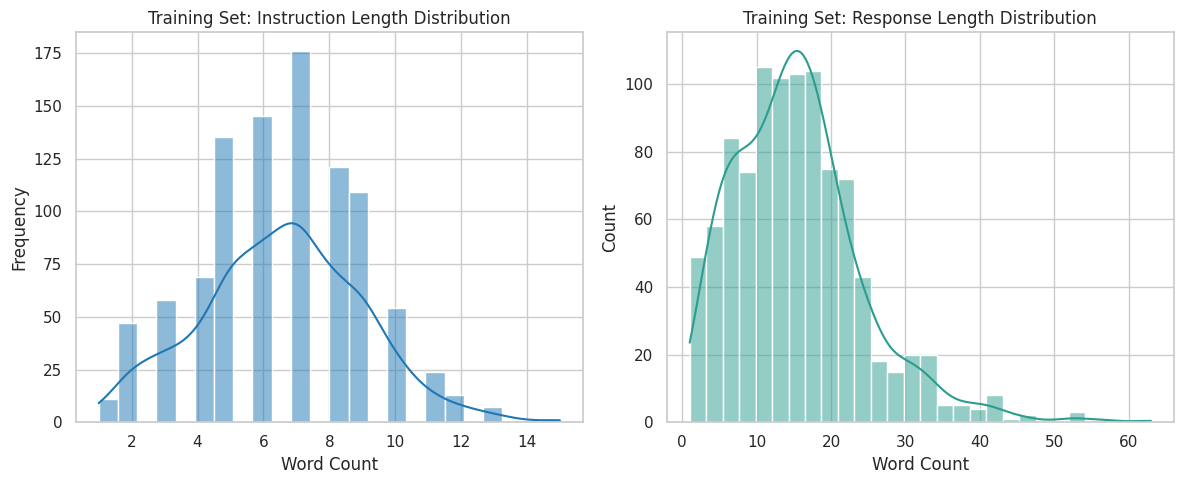

In [3]:
def prepare_data():
    if os.path.exists(DATA_PATH):
        print(f"[INFO] Loading dataset from source: {DATA_PATH}...")
        full_dataset = load_dataset("json", data_files=DATA_PATH, split="train")
    else:
        print(f"[WARN] Source file {DATA_PATH} unavailable. Generating synthetic verification data.")
        full_dataset = Dataset.from_dict({
            "instruction": ["Explain quantum mechanics.", "How do I reset my password?"] * 50,
            "response": ["It is complex.", "Go to settings and click reset."] * 50
        })

    # Stratified Split (Approximated by random shuffle)
    # Split 1: 10% Test
    split_1 = full_dataset.train_test_split(test_size=0.1, seed=42)
    test_set = split_1["test"]
    remaining = split_1["train"]

    # Split 2: 10% Validation (of remaining -> ~9% of total)
    split_2 = remaining.train_test_split(test_size=0.1, seed=42)
    train_set = split_2["train"]
    val_set = split_2["test"]

    return train_set, val_set, test_set

def inspect_data_distribution(dataset, name="Training Set"):
    # Convert to Pandas for Analysis
    df = dataset.to_pandas()
    
    # Robust Length Calculation (Handling missing keys)
    df['inst_len'] = df['instruction'].fillna("").apply(lambda x: len(str(x).split()))
    # specific handling for response/output duality
    if 'response' in df.columns:
        df['resp_len'] = df['response'].fillna("").apply(lambda x: len(str(x).split()))
    elif 'output' in df.columns:
         df['resp_len'] = df['output'].fillna("").apply(lambda x: len(str(x).split()))
    else:
        df['resp_len'] = 0

    # Visualization
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Instruction Length
    plt.subplot(1, 2, 1)
    sns.histplot(df['inst_len'], color="#1f77b4", kde=True)
    plt.title(f"{name}: Instruction Length Distribution")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    
    # Plot 2: Response Length
    plt.subplot(1, 2, 2)
    sns.histplot(df['resp_len'], color="#2a9d8f", kde=True)
    plt.title(f"{name}: Response Length Distribution")
    plt.xlabel("Word Count")
    
    plt.tight_layout()
    plt.show()

train_dataset, eval_dataset, test_dataset = prepare_data()

# --- Data Integrity Inspection ---
print("\n" + "="*50)
print("            DATASET STATISTICS            ")
print("="*50)
print(f"Total Corpus Size  : {len(train_dataset) + len(eval_dataset) + len(test_dataset)} samples")
print(f"Training Subset    : {len(train_dataset)} samples")
print(f"Validation Subset  : {len(eval_dataset)} samples")
print(f"Test Subset        : {len(test_dataset)} samples")
print("-"*50)

print("\n[DATA SAMPLE: Index 0]")
sample = train_dataset[0]
print(f"> INSTRUCTION:\n{sample.get('instruction')}")
print(f"\n> RESPONSE:\n{sample.get('response') or sample.get('output')}")
print("-"*50)

# --- Distribution Visualization ---
print("\n[ANALYSIS] Visualizing Training Corpus Distribution...")
inspect_data_distribution(train_dataset)

## 4. Model Fine-Tuning
Fine-tune the chosen base model (Mistral-7B or the optional tiny debug checkpoint) with QLoRA adapters. This keeps compute light, mirrors the hardware constraints we expect on Arciva edge devices, and still lets the model absorb Arciva-specific navigation, tagging, and workflow vocabulary.


In [4]:
# Real-Time Loss Visualization Callback
class NotebookPlotCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.val_losses = []
        self.steps = []
        self.val_steps = []
        self.start_time = None

    def on_train_begin(self, args, state, control, **kwargs):
        self.start_time = time.time()

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            if 'loss' in logs:
                self.losses.append(logs['loss'])
                self.steps.append(state.global_step)
            if 'eval_loss' in logs:
                self.val_losses.append(logs['eval_loss'])
                self.val_steps.append(state.global_step)
            
            if 'loss' in logs or 'eval_loss' in logs:
                # Calculate Estimated Time of Arrival (ETA)
                elapsed = time.time() - self.start_time
                avg_time_per_step = elapsed / state.global_step if state.global_step > 0 else 0
                remaining_steps = state.max_steps - state.global_step
                eta_seconds = int(avg_time_per_step * remaining_steps)
                eta_str = f"{eta_seconds // 60}m {eta_seconds % 60}s"

                clear_output(wait=True)
                sns.set_theme(style="whitegrid")
                plt.figure(figsize=(10, 5))
                if self.losses:
                    plt.plot(self.steps, self.losses, label='Training Loss', color='#1f77b4', linewidth=2)
                if self.val_losses:
                    plt.plot(self.val_steps, self.val_losses, label='Validation Loss', color='#d62728', marker='o', linewidth=2)
                plt.xlabel('Training Steps', fontsize=10)
                plt.ylabel('Loss Value', fontsize=10)
                plt.title(f'Training Convergence Dynamics (ETA: {eta_str})', fontsize=12, fontweight='bold')
                plt.legend()
                plt.grid(True, linestyle="--", alpha=0.4)
                plt.show()

def formatting_prompts_func(example):
    output_texts = []
    instruction = example.get('instruction')
    response = example.get('response') or example.get('output')
    if isinstance(instruction, list):
        for i, r in zip(instruction, response):
            output_texts.append(f"### Instruction:\n{i}\n\n### Response:\n{r}")
        return output_texts
    return f"### Instruction:\n{instruction}\n\n### Response:\n{response}"

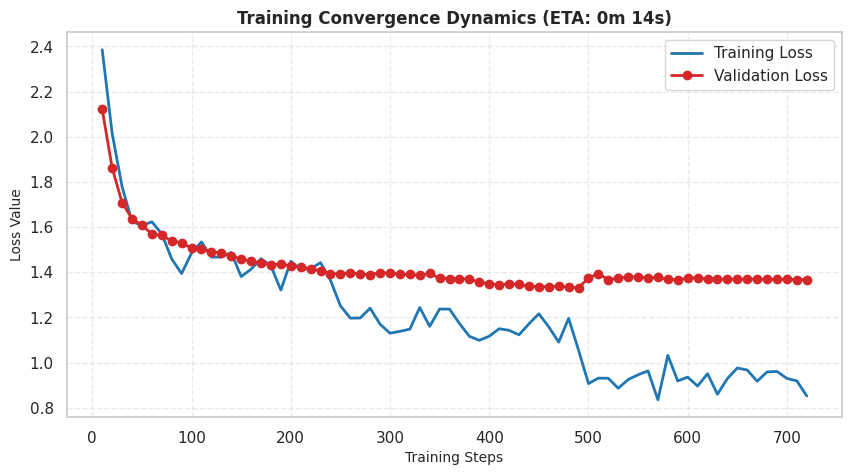

[INFO] Training concluded. Artifacts saved to: model_output


In [5]:
def run_training_pipeline(train_data, val_data):
    # Hardware Acceleration Logic
    use_gpu = torch.cuda.is_available()
    compute_dtype = torch.float16
    bf16_kwargs = {"bf16": False, "fp16": True}
    
    if use_gpu and torch.cuda.is_bf16_supported():
        print("[INFO] BF16 acceleration enabled for compatible hardware.")
        compute_dtype = torch.bfloat16
        bf16_kwargs = {"bf16": True, "fp16": False}

    # 4-bit Quantization Configuration
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
    ) if use_gpu else None

    print("[INFO] Initializing Base Model...")
    model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        quantization_config=bnb_config,
        device_map="auto" if use_gpu else "cpu",
        trust_remote_code=True,
        use_safetensors=True,
    )
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token

    # Prepare for LoRA
    model = prepare_model_for_kbit_training(model) if use_gpu else model
    peft_config = LoraConfig(
        lora_alpha=16, lora_dropout=0.1, r=64, bias="none", task_type="CAUSAL_LM"
    )

    # Training Hyperparameters
    args = SFTConfig(
        output_dir=OUTPUT_DIR,
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=TRAIN_BATCH_SIZE_GPU if use_gpu else TRAIN_BATCH_SIZE_CPU,
        gradient_accumulation_steps=GRAD_ACCUM_STEPS_GPU if use_gpu else GRAD_ACCUM_STEPS_CPU,
        learning_rate=LEARNING_RATE,
        logging_steps=LOGGING_STEPS,
        eval_strategy="steps",
        eval_steps=EVAL_STEPS,
        report_to="none",
        use_cpu=not use_gpu,
        max_length=MAX_SEQ_LENGTH,
        **bf16_kwargs
    )

    trainer = SFTTrainer(
        model=model,
        train_dataset=train_data,
        eval_dataset=val_data,
        peft_config=peft_config,
        formatting_func=formatting_prompts_func,
        processing_class=tokenizer,
        args=args,
        callbacks=[NotebookPlotCallback()]
    )

    print("[INFO] Starting Training Loop...")
    trainer.train()
    trainer.model.save_pretrained(OUTPUT_DIR)
    print(f"[INFO] Training concluded. Artifacts saved to: {OUTPUT_DIR}")
    
    # Memory Cleanup
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()

run_training_pipeline(train_dataset, eval_dataset)

## 5. Quantitative Analysis & Reporting
Compute lightweight metrics on the held-out test set to understand whether the assistant is learning Arciva patterns at all. Perplexity tracks language modeling fit, BLEU/ROUGE-L capture instruction-following fidelity, and the surrounding visualization surfaces regression risks before we scale to a larger dataset.


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


[INFO] Reloading model architecture for inference...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[METRICS] Calculating Perplexity...


Truncating train dataset:   0%|          | 0/972 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/121 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/121 [00:00<?, ? examples/s]

[METRICS] Generating responses for semantic analysis...

[INFO] Saving visualization panel to 'analysis_plots.png'...


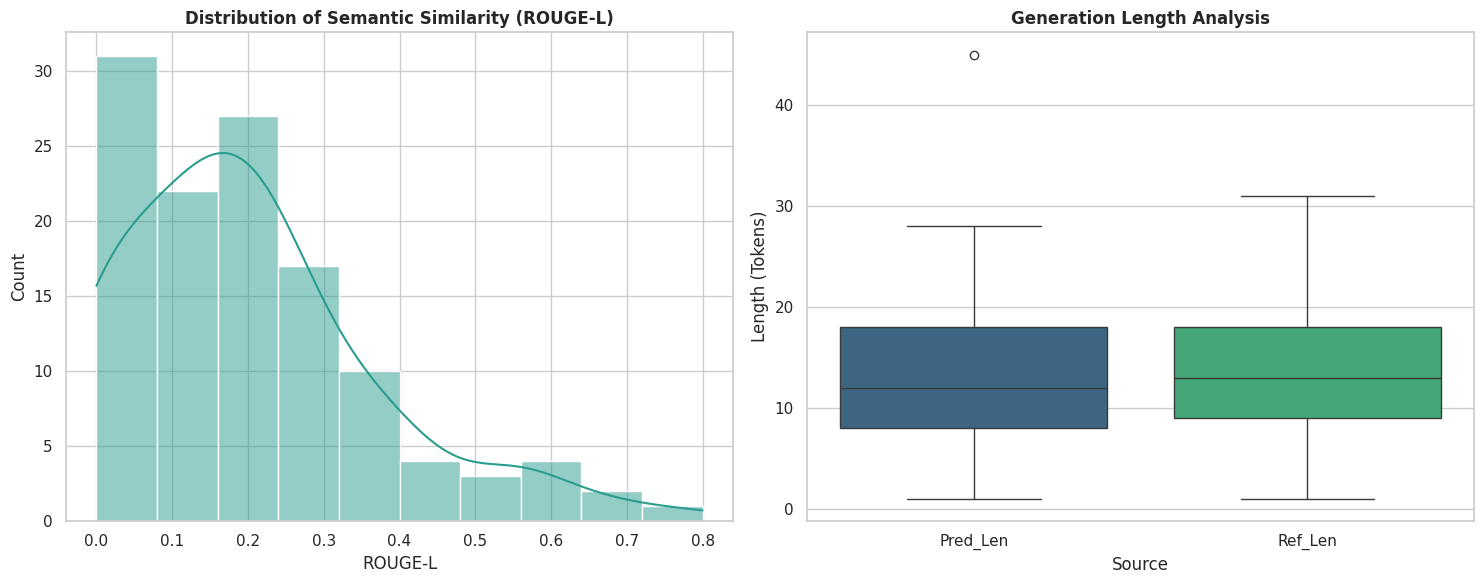


             PERFORMANCE SUMMARY             
Metric               | Value     
----------------------------------------
Test Loss            | 1.3438
Perplexity           | 3.8337
BLEU Score           | 10.08
Avg ROUGE-L          | 0.2017

[ANALYSIS] Top Performing Generations:


,Instruction,Prediction,ROUGE-L
15,How do I see the 'Software' used?,**Metadata** > **Software**.,0.800000
11,What is the shortcut to switch to Detail view?,Press the **D** key to toggle between Grid and...,0.700000
115,Kamera-Seriennummer?,**Metadata** > **Camera** > Serial Number.,0.666667



[ANALYSIS] Low Performing Generations:


,Instruction,Prediction,ROUGE-L
16,Warum sind Farben flau?,Offenbar fehlen Kontrastverstärker und Sättigu...,0.0
32,Datum-Filter zurücksetzen?,Leerlöschen.,0.0
33,Wie aktiviere ich 'Split View'?,Nicht verfügbar.,0.0


In [6]:
def evaluate_model_metrics(train_data, test_data):
    print("[INFO] Reloading model architecture for inference...")
    use_gpu = torch.cuda.is_available()

    # Inference Init (FP16/4-bit)
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        load_in_4bit=True if use_gpu else False,
        device_map="auto" if use_gpu else "cpu",
        trust_remote_code=True,
        use_safetensors=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token

    model = PeftModel.from_pretrained(base_model, OUTPUT_DIR)
    model.eval()
    
    # --- 1. Perplexity Calculation ---
    print("[METRICS] Calculating Perplexity...")
    eval_args = TrainingArguments(
        output_dir="temp_eval", 
        per_device_eval_batch_size=4, 
        report_to="none"
    )
    trainer = SFTTrainer(
        model=model,
        train_dataset=train_data, 
        eval_dataset=test_data,
        formatting_func=formatting_prompts_func,
        processing_class=tokenizer,
        args=eval_args
    )
    results = trainer.evaluate()
    loss = results["eval_loss"]
    perp = torch.exp(torch.tensor(loss))
    
    # --- 2. Generation & Similarity Analysis ---
    print("[METRICS] Generating responses for semantic analysis...")
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    
    results_data = []
    all_preds = []
    all_refs = []
    
    for i, item in enumerate(test_data):
        prompt = f"### Instruction:\n{item['instruction']}\n\n### Response:\n"
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        with torch.no_grad():
            out = model.generate(
                **inputs, 
                max_new_tokens=100, 
                do_sample=True, 
                top_p=0.9, 
                temperature=0.7,
                pad_token_id=tokenizer.pad_token_id
            )
        
        gen_text = tokenizer.decode(out[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
        ref_text = (item.get('response') or item.get('output')).strip()
        
        all_preds.append(gen_text)
        all_refs.append(ref_text)
        
        score = scorer.score(ref_text, gen_text)['rougeL'].fmeasure
        
        results_data.append({
            "Instruction": item['instruction'],
            "Prediction": gen_text,
            "Reference": ref_text,
            "ROUGE-L": score,
            "Pred_Len": len(gen_text.split()),
            "Ref_Len": len(ref_text.split())
        })

    # Calculate Corpus BLEU
    bleu = sacrebleu.corpus_bleu(all_preds, [all_refs])
    
    df_results = pd.DataFrame(results_data)
    
    # --- Visualization Panel (Saved to Disk) ---
    print("\n[INFO] Saving visualization panel to 'analysis_plots.png'...")
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    
    sns.histplot(df_results["ROUGE-L"], bins=10, kde=True, ax=ax[0], color="#2a9d8f")
    ax[0].set_title("Distribution of Semantic Similarity (ROUGE-L)", fontweight='bold')
    
    df_melt = df_results.melt(value_vars=["Pred_Len", "Ref_Len"], var_name="Source", value_name="Length (Tokens)")
    sns.boxplot(x="Source", y="Length (Tokens)", hue="Source", data=df_melt, ax=ax[1], palette="viridis", legend=False)
    ax[1].set_title("Generation Length Analysis", fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # --- Executive Summary Table ---
    print("\n" + "="*50)
    print("             PERFORMANCE SUMMARY             ")
    print("="*50)
    print(f"{ 'Metric':<20} | { 'Value':<10}")
    print("-"*40)
    print(f"{ 'Test Loss':<20} | {loss:.4f}")
    print(f"{ 'Perplexity':<20} | {perp:.4f}")
    print(f"{ 'BLEU Score':<20} | {bleu.score:.2f}")
    print(f"{ 'Avg ROUGE-L':<20} | {df_results['ROUGE-L'].mean():.4f}")
    print("="*50)
    
    print("\n[ANALYSIS] Top Performing Generations:")
    display(df_results.nlargest(3, "ROUGE-L")[["Instruction", "Prediction", "ROUGE-L"]])
    
    print("\n[ANALYSIS] Low Performing Generations:")
    display(df_results.nsmallest(3, "ROUGE-L")[["Instruction", "Prediction", "ROUGE-L"]])

    # Pre-Merge Cleanup
    del model
    gc.collect()
    torch.cuda.empty_cache()

evaluate_model_metrics(train_dataset, test_dataset)

## 6. Interactive Performance Dashboard
Sample generations across Train/Validation/Test splits to inspect strengths and failure modes. The table view mimics how Arciva's eventual in-product assistant review tooling could look—search by topic, sort by quality, and compare references to predictions when curating new training data.


In [7]:
# google.colab data_table handled in imports cell

def generate_interactive_dashboard(train_set, val_set, test_set, n_samples=20):
    print(f"[DASHBOARD] Initializing Interactive Analysis (Sampling N={n_samples} per split)...")
    
    # Reload architecture for clean inference context
    use_gpu = torch.cuda.is_available()
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME, 
        load_in_4bit=True if use_gpu else False, 
        device_map="auto" if use_gpu else "cpu", 
        trust_remote_code=True,
        use_safetensors=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    tokenizer.pad_token = tokenizer.eos_token
    model = PeftModel.from_pretrained(base_model, OUTPUT_DIR)
    model.eval()

    splits = {
        "Train": train_set,
        "Validation": val_set,
        "Test": test_set
    }
    
    dashboard_data = []
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

    for split_name, dataset in splits.items():
        # Safe Random Sampling
        n = min(n_samples, len(dataset))
        subset = dataset.shuffle(seed=42).select(range(n))
        
        print(f"> Processing split: {split_name} ({n} items)...")
        for item in subset:
            prompt = f"### Instruction:\n{item['instruction']}\n\n### Response:\n"
            inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
            
            with torch.no_grad():
                out = model.generate(
                    **inputs, 
                    max_new_tokens=100, 
                    do_sample=True, 
                    top_p=0.9, 
                    temperature=0.7,
                    pad_token_id=tokenizer.pad_token_id
                )
            
            gen_text = tokenizer.decode(out[0][inputs.input_ids.shape[1]:], skip_special_tokens=True).strip()
            ref_text = (item.get('response') or item.get('output')).strip()
            score = scorer.score(ref_text, gen_text)['rougeL'].fmeasure
            
            dashboard_data.append({
                "Split": split_name,
                "Instruction": item['instruction'],
                "Reference": ref_text,
                "Prediction": gen_text,
                "ROUGE-L": round(score, 4)
            })

    df = pd.DataFrame(dashboard_data)
    
    # Render Interactive Table
    print("[SUCCESS] Dashboard generated. Use the table below to Sort, Filter, and Search.")
    if HAS_COLAB and data_table is not None:
        print('[INFO] Rendering interactive DataTable (Colab only).')
        data_table.enable_dataframe_formatter()
        display(data_table.DataTable(df, include_index=False, num_rows_per_page=10))
    else:
        print('[INFO] google.colab data_table unavailable; showing pandas preview instead.')
        display(df.head(min(10, len(df))))
    
    # Cleanup
    del model
    gc.collect()
    torch.cuda.empty_cache()
    return df

generate_interactive_dashboard(train_dataset, eval_dataset, test_dataset)

[DASHBOARD] Initializing Interactive Analysis (Sampling N=20 per split)...


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

> Processing split: Train (20 items)...
> Processing split: Validation (20 items)...
> Processing split: Test (20 items)...
[SUCCESS] Dashboard generated. Use the table below to Sort, Filter, and Search.
[INFO] google.colab data_table unavailable; showing pandas preview instead.


,Split,Instruction,Reference,Prediction,ROUGE-L
0,Train,Wie entstaple ich?,**Stacking** in der TopBar deaktivieren.,Nutzen Sie die **Unstapeln**-Taste (oder **Shi...,0.0000
1,Train,How do I export solely based on 'Pick' status?,"Filter by **Pick**, Select All, then Export.",Export > Filter by 'Pick' > Select > Export.,0.7692
2,Train,Was zeigt die Zahl am 'Filters'-Button?,Die Zahl (Badge) am **Filters**-Button zeigt a...,"Die Zahl zeigt an, wie viele Filter-Regeln akt...",0.6667
3,Train,How do I navigate via the 'Rail'?,"When the Sidebar is collapsed, move the mouse ...","In **Detail** view, the sidebar is the Rail. S...",0.3000
4,Train,Wie klappe ich die Projektübersicht aus?,Klicken Sie in der Seitenleiste auf die **Over...,Klicken Sie in der **Projects**-Sektion auf de...,0.3030
5,Train,Wie erkennt der Client fehlendes `exiftool`?,Das Backend prüft die Umgebung und sendet eine...,Er erhält einen 500-Fehler mit der Meldung `Mi...,0.0833
6,Train,Wie drehe ich um 90 Grad?,**Quick Fix** > **Crop** hat Buttons für +90/-...,**Rotation** im Inspektor.,0.1429
7,Train,How can I see when the project was created?,The **Created** date is displayed in the **Ove...,"In the **Overview** tab, look for the **Create...",0.3333
8,Train,Wie setze ich die Ansicht nach dem Filtern zur...,Klicken Sie auf **Reset** im Filter-Dialog.,Klicken Sie in der Regel auf **Reset** in der ...,0.5556
9,Train,How do I change the color temperature of my ph...,"To adjust the color temperature, go to the **Q...","In the **Quick Fix** panel, expand the **Color...",0.5455


,Split,Instruction,Reference,Prediction,ROUGE-L
0,Train,Wie entstaple ich?,**Stacking** in der TopBar deaktivieren.,Nutzen Sie die **Unstapeln**-Taste (oder **Shi...,0.0000
1,Train,How do I export solely based on 'Pick' status?,"Filter by **Pick**, Select All, then Export.",Export > Filter by 'Pick' > Select > Export.,0.7692
2,Train,Was zeigt die Zahl am 'Filters'-Button?,Die Zahl (Badge) am **Filters**-Button zeigt a...,"Die Zahl zeigt an, wie viele Filter-Regeln akt...",0.6667
3,Train,How do I navigate via the 'Rail'?,"When the Sidebar is collapsed, move the mouse ...","In **Detail** view, the sidebar is the Rail. S...",0.3000
4,Train,Wie klappe ich die Projektübersicht aus?,Klicken Sie in der Seitenleiste auf die **Over...,Klicken Sie in der **Projects**-Sektion auf de...,0.3030
5,Train,Wie erkennt der Client fehlendes `exiftool`?,Das Backend prüft die Umgebung und sendet eine...,Er erhält einen 500-Fehler mit der Meldung `Mi...,0.0833
6,Train,Wie drehe ich um 90 Grad?,**Quick Fix** > **Crop** hat Buttons für +90/-...,**Rotation** im Inspektor.,0.1429
7,Train,How can I see when the project was created?,The **Created** date is displayed in the **Ove...,"In the **Overview** tab, look for the **Create...",0.3333
8,Train,Wie setze ich die Ansicht nach dem Filtern zur...,Klicken Sie auf **Reset** im Filter-Dialog.,Klicken Sie in der Regel auf **Reset** in der ...,0.5556
9,Train,How do I change the color temperature of my ph...,"To adjust the color temperature, go to the **Q...","In the **Quick Fix** panel, expand the **Color...",0.5455


## 7. Artifact Compilation & Export
Merge the trained adapters into the fp16 backbone to create a portable checkpoint. These artifacts are the starting point for Arciva's edge deployment experiments (quantization, Jetson benchmarking, and FastAPI integration tests).


In [8]:
def export_final_model():
    print(f"[EXPORT] Initializing merge sequence. Target: {FINAL_SAVE_DIR}...")
    
    # Precision MUST be float16 for merging
    base_model = AutoModelForCausalLM.from_pretrained(
        MODEL_NAME,
        return_dict=True,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True,
        use_safetensors=True,
    )
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token

    model = PeftModel.from_pretrained(base_model, OUTPUT_DIR)
    model = model.merge_and_unload()
    
    model.save_pretrained(FINAL_SAVE_DIR)
    tokenizer.save_pretrained(FINAL_SAVE_DIR)
    print(f"[SUCCESS] Standalone model exported to ./{FINAL_SAVE_DIR}")

export_final_model()

`torch_dtype` is deprecated! Use `dtype` instead!


[EXPORT] Initializing merge sequence. Target: final_merged_model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

[SUCCESS] Standalone model exported to ./final_merged_model
